# Except for some extremely minor revisions, all of the credit for this notebook goes to Matteo Esposito!

In [14]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import copy
import camb
from utilities import *
%load_ext autoreload
%autoreload 2
#Plotting settings
%matplotlib inline
plt.rcParams.update({'axes.labelsize': 'x-large'})
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
linestyles=['solid', '--', '-.', ':', (0, (3, 5, 1, 5, 1, 5)), (0, (1, 10))]
colors=list(mcolors.TABLEAU_COLORS.values())#['orange', 'blue', 'green', 'magenta', 'red', 'cyan']

cosmo_dict = make_cosmo_suite(fname='/home/lfinkbei/Documents/Master/' + \
    'CAMB_notebooks/shared/data/cosmologies.dat', use_sigma8=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def get_camb_Pk(As_factor=1., mnu=0., sim_idx=0, z_idx=range(5), z=None,
    ns = 0.96, en_dens_fact = 1., s12 = None, verbose=True):
    #Set up a new set of parameters for CAMB
    try:
        # Lukas. This line is obscure.
        zz = [1/cosmo_dict['Columbus_%d_%d' %(sim_idx, i)]['expfactor']-1 for i in z_idx]
        z_idx = z_idx[0]
    except:
        pass
    
    if z is not None:
        zz = z

    cosmo_params = cosmo_dict['Columbus_%d_%d' %(sim_idx, z_idx)]
    pars = camb.CAMBparams()
    h = cosmo_params['hubble']
    ''' It's likely enough that "en_dens_fact" is short for "energy density
    factor," but I'm still not sure about the purpose. Does it simply
    enforce a kind of normalization? '''
    ombh2 = en_dens_fact*cosmo_params['omega_baryon']*h**2
    omch2 = en_dens_fact*cosmo_params['omega_cdm']*h**2
    omk = 1-(cosmo_params['omega_cdm']+cosmo_params['omega_de']+cosmo_params['omega_baryon'])
    try:
        w0 = cosmo_params['w0']
    except:
        w0=-1
    try:
        wa = cosmo_params['wa']
    except:
        wa=0
    if cosmo_params['A_s'] != None:
        As = cosmo_params['A_s']  
    else:
        raise RuntimeError('Nope, you passed cosmo_dict with sigma8=True. Wrong.')
    
    '''! Lukas
    This pair of lines is obscure, and reminds me of my failed attempt at
    getting CAMB to recognize my massive neutrinos... did Matteo somehow get
    it to really work?
    '''
    pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=en_dens_fact*mnu,
        omk=omk, tau=0.0952)
    pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2-pars.omnuh2,
        mnu=en_dens_fact*mnu, omk=omk, tau=0.0952)
    
    ''' Lukas
    I'm commenting out these definitions because they are unused.
    fb = pars.ombh2/(pars.ombh2+pars.omch2+pars.omnuh2)
    fnu = pars.omnuh2/(pars.ombh2+pars.omch2+pars.omnuh2)
    '''
    
    pars.InitPower.set_params(As=As*As_factor, ns=ns, r=0, nt=0.0, ntrun=0.0)
    # Lukas. I added the "/ h"
    pars.set_matter_power(redshifts=zz, kmax=20.0 / h)
    pars.NonLinear = camb.model.NonLinear_none
    pars.WantCls = False
    pars.WantScalars = False
    pars.Want_CMB = False
    pars.DoLensing = False
    pars.YHe = 0.24
    pars.set_accuracy(AccuracyBoost=2)
    if w0 != -1 or wa != 0:
        pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='ppf') 

    results = camb.get_results(pars)

    R, zz, sigma12 = results.get_sigmaR(12, hubble_units=False, return_R_z=True)
    #camb_sigma12.append(np.array(sigma12))
    old_As = As

    if s12 is not None:
        As = As * s12**2/sigma12[0]**2
        pars.InitPower.set_params(As=As*As_factor, ns=ns, r=0, nt=0.0,
            ntrun=0.0)
        results = camb.get_results(pars)
        R, zz, sigma12 = results.get_sigmaR(12, hubble_units=False,
            return_R_z=True)
    
    # Lukas: I changed var1 and var2 to 8, they were both 2 before
    # Lukas: I changed npoints to 10000, it was 200 before
    kh, z, pkh = results.get_matter_power_spectrum(var1=2, var2=2, minkh=1e-4/h,
        maxkh=20/h, npoints = 10000) 
    settings = {'As_factor': As_factor, 'mnu': mnu, 'sim_idx': sim_idx,
        'z_idx': z_idx, 'ns': ns, 'en_dens_fact': en_dens_fact, 's12': s12}
    
    if verbose:
        print('Computed Pk with settings:')
        print(settings)
        print('\n')
    
    return {'kk': kh*h, 'zz': z, 'Pk': pkh/(h**3), 's12': sigma12,
            'As_factor': As/old_As, 'Settings': settings}

In [16]:
def get_all_cosmo_camb_Pk(As_factor=1., mnu=0., z_idx=range(5), ns = 0.96,
    en_dens_fact = 1., s12 = None, nsims=9, verbose=True):
    if s12 is not None:
        return [get_camb_Pk(As_factor=As_factor, mnu=mnu, sim_idx=i,
            z_idx=z_idx, ns=ns, en_dens_fact=en_dens_fact, s12=sigma12,
            verbose=verbose) for i, sigma12 in zip(range(nsims), s12)]
    if type(As_factor) in [list, tuple, np.ndarray]:
        return [get_camb_Pk(As_factor=Asf, mnu=mnu, sim_idx=i, z_idx=z_idx,
            ns=ns, en_dens_fact=en_dens_fact, s12=s12, verbose=verbose) for \
            i, Asf in zip(range(nsims), As_factor)]
    return [get_camb_Pk(As_factor=As_factor, mnu=mnu, sim_idx=i, z_idx=z_idx,
        ns=ns, en_dens_fact=en_dens_fact, s12=s12, verbose=verbose) for \
        i in range(nsims)]

In [17]:
nsims = 9
LCDM = get_all_cosmo_camb_Pk(verbose=False)

mnu_Lukas = 0.1998324308090579 # this is intended to mimic a physical neutrino
# density of 0.002148659574468
mnu_Matteo = 0.3
nuCDM = get_all_cosmo_camb_Pk(mnu=mnu_Lukas, verbose=False)
# Lukas: for the purposes of debugging, ignore the rest of these
if False:
    var_ns_LCDM = get_all_cosmo_camb_Pk(ns=0.9, verbose=False)
    var_ns_nuCDM = get_all_cosmo_camb_Pk(mnu=0.3, ns=0.9, verbose=False)
    var_omb_LCDM = get_all_cosmo_camb_Pk(en_dens_fact=1.2,
        s12=[LCDM[i]['s12'][4] for i in range(nsims)], verbose=False)
    var_omb_nuCDM = get_all_cosmo_camb_Pk(mnu=0.3, en_dens_fact=1.2,
        As_factor=[var_omb_LCDM[i]['As_factor'] for i in range(nsims)],
        verbose=False)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


In [18]:
LCDM[2]['s12'][4]

0.8246705799979576

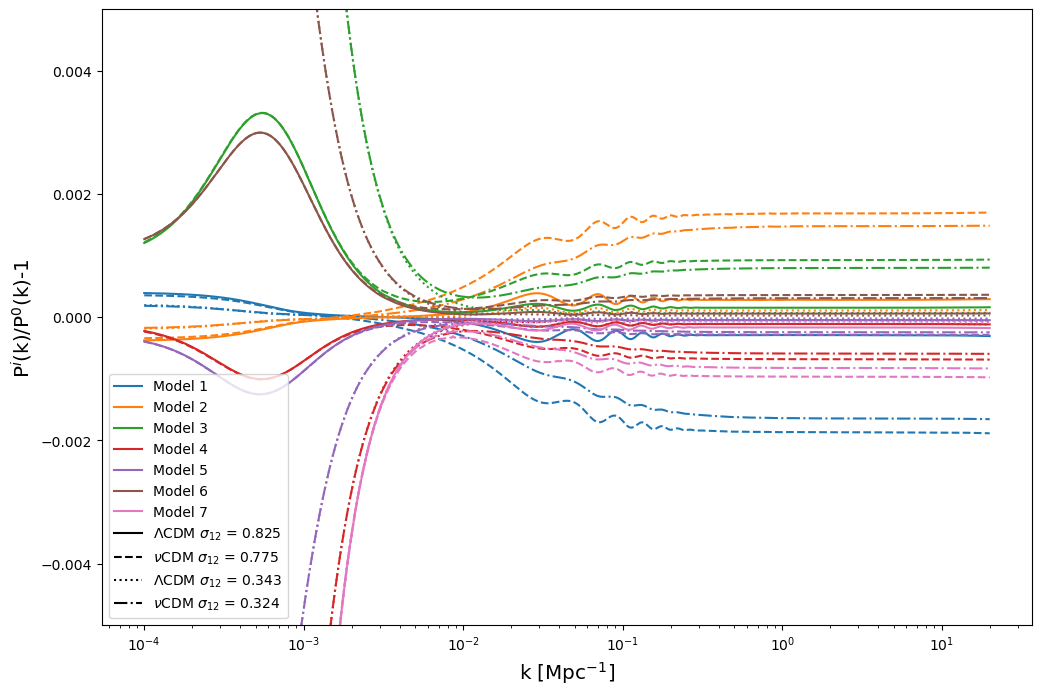

In [19]:
z_idx = 4
for i in range(1, 8):
    p = plt.plot(LCDM[i]['kk'], LCDM[i]['Pk'][z_idx]/LCDM[0]['Pk'][z_idx]-1, label='Model {}'.format(i))
    plt.plot(nuCDM[i]['kk'], nuCDM[i]['Pk'][z_idx]/nuCDM[0]['Pk'][z_idx]-1, ls='--', color=p[0].get_color())
    plt.plot(LCDM[i]['kk'], LCDM[i]['Pk'][0]/LCDM[0]['Pk'][0]-1, ls=':', color=p[0].get_color())
    plt.plot(nuCDM[i]['kk'], nuCDM[i]['Pk'][0]/nuCDM[0]['Pk'][0]-1, ls='-.', color=p[0].get_color())

plt.plot([], [], ls='-', color='black', label=r'$\Lambda$CDM $\sigma_{12}$ = %.3f' %(LCDM[0]['s12'][z_idx]))
plt.plot([], [], ls='--', color='black', label=r'$\nu$CDM $\sigma_{12}$ = %.3f' %(nuCDM[0]['s12'][z_idx]))
plt.plot([], [], ls=':', color='black', label=r'$\Lambda$CDM $\sigma_{12}$ = %.3f' %(LCDM[0]['s12'][0]))
plt.plot([], [], ls='-.', color='black', label=r'$\nu$CDM $\sigma_{12}$ = %.3f' %(nuCDM[0]['s12'][0]))
plt.xscale('log')
plt.ylim([-0.005, 0.005])
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.ylabel(r'P$^{i}$(k)/P$^{0}$(k)-1')
plt.legend()
plt.savefig('Plots/All_Pk_ratio_to_model0_z{}.pdf'.format(z_idx))

In [20]:
for i in range(nsims):
    print('%d %f' %(i, 1/cosmo_dict['Columbus_%d_4' %i]['expfactor']-1))

0 2.000000
1 1.760980
2 2.231260
3 2.100420
4 1.922590
5 1.972600
6 2.031470
7 1.938160
8 2.019714


In [21]:
#Computing model 0 at the redshift of model 1 in the last redshift bin. 
#We want to compute the ratio Pnu/P and see if it is comparable with what we see in the next plot
z_idx = 4
z1 = LCDM[1]['zz'][z_idx]
z1_nu = nuCDM[1]['zz'][z_idx]
LCDM_var_z = get_camb_Pk(sim_idx=0, z=[z1])
nuCDM_var_z = get_camb_Pk(mnu=0.3, sim_idx=0, z=[z1_nu])

Computed Pk with settings:
{'As_factor': 1.0, 'mnu': 0.0, 'sim_idx': 0, 'z_idx': 0, 'ns': 0.96, 'en_dens_fact': 1.0, 's12': None}


Computed Pk with settings:
{'As_factor': 1.0, 'mnu': 0.3, 'sim_idx': 0, 'z_idx': 0, 'ns': 0.96, 'en_dens_fact': 1.0, 's12': None}




In [22]:
z1

1.76098

In [30]:
np.save('LCDM.npy', LCDM, allow_pickle=True)
np.save('nuCDM.npy', nuCDM, allow_pickle=True)

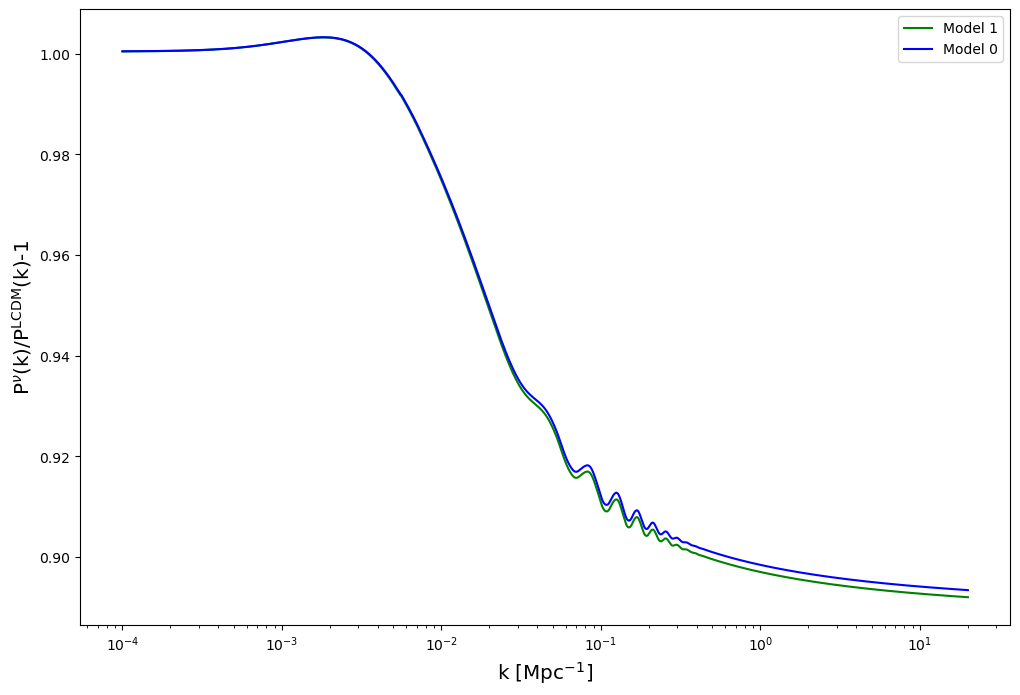

In [23]:
p = plt.plot(LCDM[1]['kk'], nuCDM[1]['Pk'][z_idx]/LCDM[1]['Pk'][z_idx], c='green', label='Model {}'.format(1))
p = plt.plot(LCDM[0]['kk'], nuCDM[0]['Pk'][z_idx]/LCDM[0]['Pk'][z_idx], c='blue', label='Model {}'.format(0))
#plt.plot(LCDM_var_z['kk'], nuCDM_var_z['Pk'][0]/LCDM_var_z['Pk'][0]-1, ls='--', c='orange',label='Model 0 at Model 1 redshift')
plt.legend()
plt.xscale('log')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.ylabel(r'P$^{\nu}$(k)/P$^{\rm LCDM}$(k)-1')
plt.savefig('Plots/going_well.pdf')

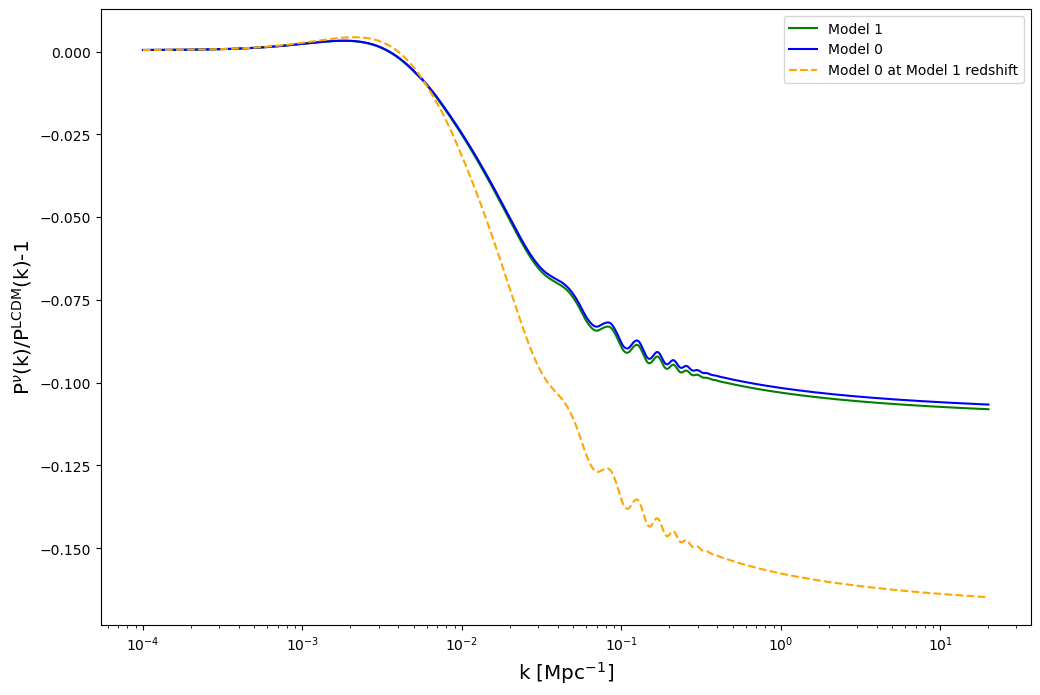

In [24]:
p = plt.plot(LCDM[1]['kk'], nuCDM[1]['Pk'][z_idx]/LCDM[1]['Pk'][z_idx]-1, c='green', label='Model {}'.format(1))
p = plt.plot(LCDM[0]['kk'], nuCDM[0]['Pk'][z_idx]/LCDM[0]['Pk'][z_idx]-1, c='blue', label='Model {}'.format(0))
plt.plot(LCDM_var_z['kk'], nuCDM_var_z['Pk'][0]/LCDM_var_z['Pk'][0]-1, ls='--', c='orange',label='Model 0 at Model 1 redshift')
plt.legend()
plt.xscale('log')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.ylabel(r'P$^{\nu}$(k)/P$^{\rm LCDM}$(k)-1')
plt.savefig('Plots/not_going_well.pdf')

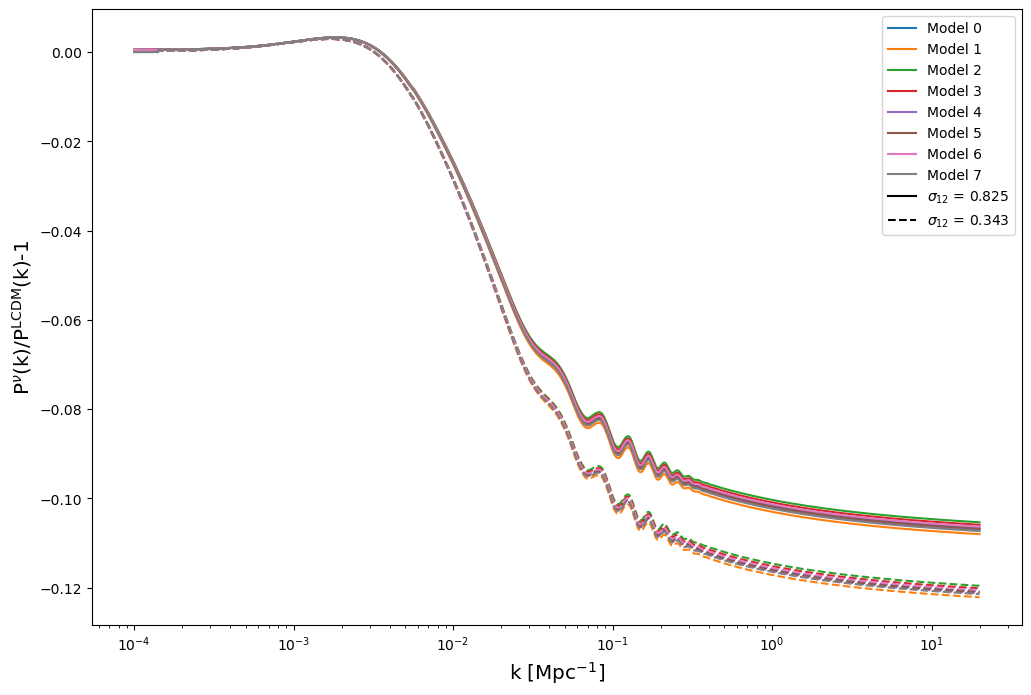

In [25]:
z_idx = 4
for i in range(8):
    p = plt.plot(LCDM[i]['kk'], nuCDM[i]['Pk'][z_idx]/LCDM[i]['Pk'][z_idx]-1, label='Model {}'.format(i))
    plt.plot(LCDM[i]['kk'], nuCDM[i]['Pk'][0]/LCDM[i]['Pk'][0]-1, ls='--', color=p[0].get_color())
    #plt.plot(kh_diff_cosmo[i], pkh_diff_cosmo[i][0]/pkh_diff_cosmo[0][0]-1, ls=':', color=p[0].get_color())
    #plt.plot(nu_kh_diff_cosmo[i], nu_pkh_diff_cosmo[i][0]/nu_pkh_diff_cosmo[0][0]-1, ls='-.', color=p[0].get_color())

plt.plot([], [], ls='-', color='black', label=r'$\sigma_{12}$ = %.3f' %(LCDM[0]['s12'][z_idx]))
plt.plot([], [], ls='--', color='black', label=r'$\sigma_{12}$ = %.3f' %(LCDM[0]['s12'][0]))
#plt.plot([], [], ls=':', color='black', label=r'$\Lambda$CDM z = 0')
#plt.plot([], [], ls='-.', color='black', label=r'$\nu$CDM z = 0')
plt.xscale('log')
#plt.ylim([-0.005, 0.005])
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.ylabel(r'P$^{\nu}$(k)/P$^{\rm LCDM}$(k)-1')
plt.legend()
plt.savefig('Plots/Pk_ratio_to_nuCDM_z{}.pdf'.format(z_idx))

NameError: name 'var_omb_nuCDM' is not defined

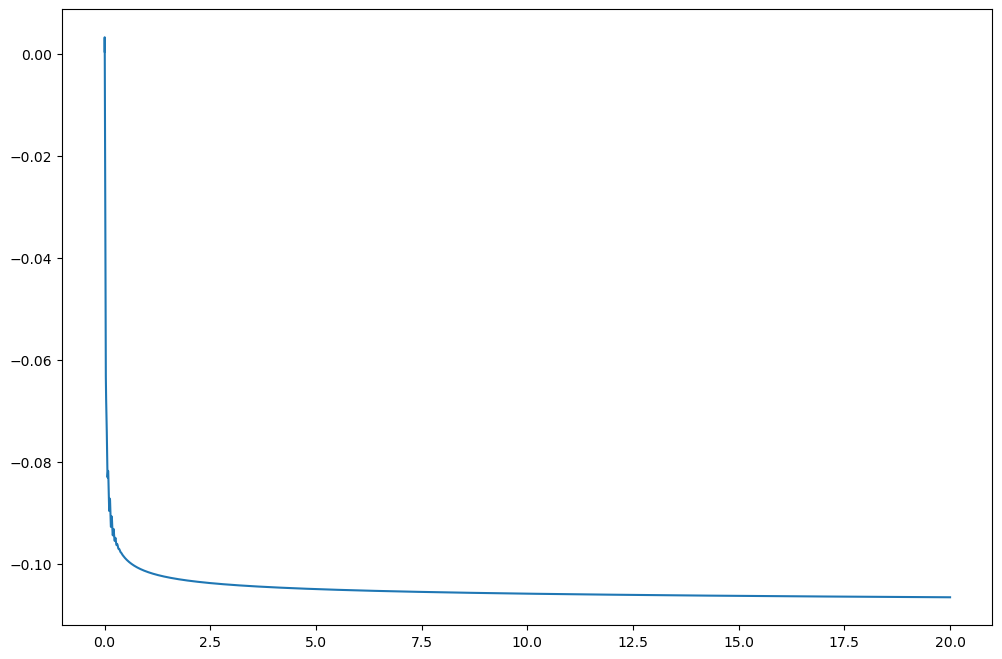

In [26]:
z_idx = 4
for i in range(nsims):
    p = plt.plot(LCDM[0]['kk'], nuCDM[0]['Pk'][z_idx]/LCDM[0]['Pk'][z_idx]-1, label = 'Model {}'.format(i))
    plt.plot(LCDM[0]['kk']/1.2, var_omb_nuCDM[0]['Pk'][z_idx]/var_omb_LCDM[0]['Pk'][z_idx]-1, ls='--', color=p[0].get_color())
plt.plot([], [], ls='-', color='black', label='Ref')
plt.plot([], [], ls='--', color='black', label=r'Model with increased energy density')
plt.legend()
plt.xscale('log')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.ylabel(r'P$^{\nu}$(k)/P$^{\rm LCDM}$(k)-1')
plt.savefig('Plots/Pk_ratio_to_nuCDM_var_omb_z{}.pdf'.format(z_idx))

In [ ]:
z_idx = 4
for i in range(nsims):
    p1 = plt.plot(LCDM[i]['kk'], nuCDM[i]['Pk'][z_idx]/LCDM[i]['Pk'][z_idx]-1, label = 'Model {}'.format(i))
    plt.plot(LCDM[i]['kk'], var_ns_nuCDM[i]['Pk'][z_idx]/var_ns_LCDM[i]['Pk'][z_idx]-1, ls='--', color=p1[0].get_color())
plt.plot([], [], ls='-', color='black', label='Ref')
plt.plot([], [], ls='--', color='black', label=r'Model with increased $n_s$')
plt.legend()
plt.xscale('log')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.ylabel(r'P$^{\nu}$(k)/P$^{\rm LCDM}$(k)-1')
plt.savefig('Plots/Pk_ratio_to_nuCDM_var_ns_z{}.pdf'.format(z_idx))

In [ ]:
##### To do #####
#Try classy
#Check reps in bacco
#Write summary in Wiki